In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

gpt2, gpt2_tokenizer, gpt2_data, gpt2_ratio = load_stuff("gpt2")
neo, neo_tokenizer, neo_data, neo_ratio = load_stuff("EleutherAI/gpt-neo-125M")
pythia, pythia_tokenizer, pythia_data, pythia_ratio = load_stuff("EleutherAI/pythia-125m")

Using custom data configuration default-17b5822e070b1eaf
Found cached dataset json (/mnt/ssd-1/nora/huggingface/datasets/json/default-17b5822e070b1eaf/0.0.0)


Using custom data configuration default-17b5822e070b1eaf


Using custom data configuration default-17b5822e070b1eaf
Using custom data configuration default-17b5822e070b1eaf


In [2]:
from itertools import islice
from torch.utils.data import DataLoader
from typing import Literal
from transformers import PreTrainedModel
from tqdm.auto import tqdm
from white_box.intervention import ablate_layer
from white_box.utils import send_to_device
import torch as th


@th.autocast("cuda", enabled=th.cuda.is_available())
@th.no_grad()
def run_layer_ablation(
    model: PreTrainedModel,
    data,
    ratio,
    limit: int = 50,
    method: Literal["resample", "mean", "zero"] = "resample"
):
    losses = []
    model.eval()

    device = model.device
    N = min(len(data), limit)
    L = model.config.num_hidden_layers
    baselines = th.zeros(N, dtype=th.float32, device=device)
    losses = th.zeros(N, L, dtype=th.float32, device=device)

    dl = DataLoader(data, batch_size=16)
    pbar = tqdm(islice(dl, limit), total=limit)
    for batch in pbar:
        batch = send_to_device(batch, device)
        i = pbar.n

        baselines[i] = model(**batch, labels=batch['input_ids']).loss * ratio
        for j in range(L):
            with ablate_layer(model, j, method=method):
                outputs = model(**batch, labels=batch['input_ids'])
                losses[i, j] = outputs.loss * ratio

    return losses, baselines

In [3]:
gpt2_losses_resample, gpt2_baseline = run_layer_ablation(
    gpt2, gpt2_data, gpt2_ratio, method="resample"
)
gpt2_losses_mean, _ = run_layer_ablation(
    gpt2, gpt2_data, gpt2_ratio, method="mean"
)
gpt2_losses_zero, _ = run_layer_ablation(
    gpt2, gpt2_data, gpt2_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
neo_losses_resample, neo_baseline = run_layer_ablation(
    neo, neo_data, neo_ratio, method="resample"
)
neo_losses_mean, _ = run_layer_ablation(
    neo, neo_data, neo_ratio, method="mean"
)
neo_losses_zero, _ = run_layer_ablation(
    neo, neo_data, neo_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
pythia_losses_resample, pythia_baseline = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="resample"
)
pythia_losses_mean, _ = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="mean"
)
pythia_losses_zero, _ = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px


def plot_losses(losses, name, baseline = None, tick_step = 1):
    # Add confidence interval bands based on standard error
    mean = losses.mean(dim=0)
    stderr = losses.std(dim=0) / losses.shape[0] ** 0.5
    plt.fill_between(
        range(len(mean)),
        mean - stderr * 1.96,
        mean + stderr * 1.96,
        alpha=0.2
    )
    plt.plot(mean, label=name, marker="o")

    if baseline is not None:
        plt.hlines(
            baseline, 0, len(mean) - 1,
            linestyles="dashed", label=f"Baseline"
        )
        
    plt.ylim(0, mean.max() * 1.1)
    plt.xticks(range(0, len(mean), tick_step))
    plt.xlabel("Layer ablated")
    plt.ylabel("bits per byte")

Text(0.5, 1.0, 'Comparing layer ablation methods for GPT-2 (125M)')

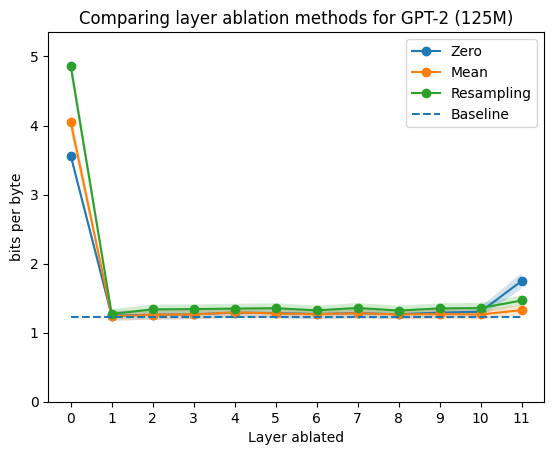

In [5]:
plot_losses(gpt2_losses_zero.cpu(), "Zero")
plot_losses(gpt2_losses_mean.cpu(), "Mean")
plot_losses(gpt2_losses_resample.cpu(), "Resampling", gpt2_baseline.mean().item())
plt.legend()
plt.title("Comparing layer ablation methods for GPT-2 (125M)")

Text(0.5, 1.0, 'Comparing layer ablation methods for Pythia (125M)')

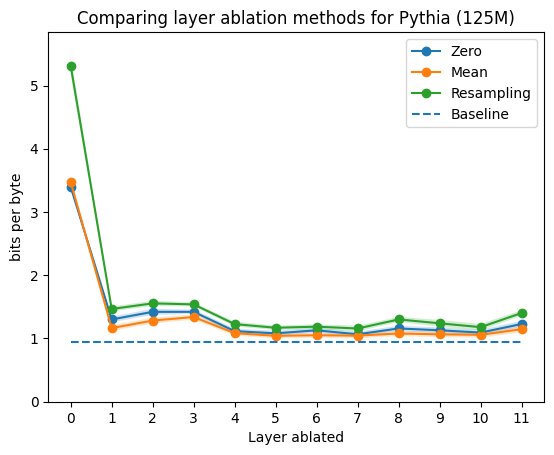

In [10]:
plot_losses(pythia_losses_zero.cpu(), "Zero")
plot_losses(pythia_losses_mean.cpu(), "Mean")
plot_losses(pythia_losses_resample.cpu(), "Resampling", pythia_baseline.mean().item())
plt.legend()
plt.title("Comparing layer ablation methods for Pythia (125M)")

Text(0.5, 1.0, 'Comparing layer ablation methods for GPT Neo (125M)')

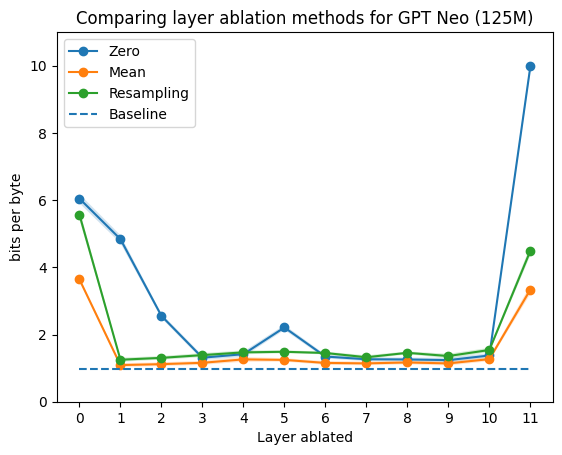

In [11]:
plot_losses(neo_losses_zero.cpu(), "Zero")
plot_losses(neo_losses_mean.cpu(), "Mean")
plot_losses(neo_losses_resample.cpu(), "Resampling", neo_baseline.mean().item())
plt.ylim(0, 11)
plt.legend()
plt.title("Comparing layer ablation methods for GPT Neo (125M)")